In [1]:
######Spatial linear regression model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from numpy.random import *
from scipy import optimize
import seaborn as sns

#np.random.seed(98537)

In [2]:
##乱数を生成する関数を設定
#多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id

#多変量正規分布の乱数を生成する関数
def rmvnorm(mu, Cov, hh, k):
    s = mu + np.random.normal(0, 1, hh*k).reshape(hh, k)
    P = np.linalg.cholesky(Cov)
    y = np.dot(P, s.T).T
    return y

#任意の相関行列を作る関数
def CorM(col, lower, upper, eigen_lower, eigen_upper, pattern):
    #相関行列の初期値を定義する
    if pattern==1:
        Prob = np.abs(lower) / (np.abs(lower) + np.abs(upper))
        z = np.random.binomial(1, Prob, col*col); z[z==0] = -1
        cov_vec = np.random.beta(1.0, 3.0, col*col) * z   #相関係数の乱数ベクトルを作成
    else:
        cov_vec = np.random.uniform(lower, upper, col*col)   #相関係数の乱数ベクトルを作成
    rho = np.tril(cov_vec.reshape(col, col), k=-1)   #乱数ベクトルを下三角行列化
    Sigma = (rho + rho.T) + np.diag(np.repeat(1, col))   #対角成分を1にする
    
    #相関行列を正定値行列に変更
    #固有値分解を実行
    eigen = np.linalg.eigh(Sigma)
    eigen_val = eigen[0] 
    eigen_vec = eigen[1]
    
    #固有値が負の数値を正にする
    for i in range(col):
        if eigen_val[i] < 0:
            eigen_val[i] = np.random.uniform(eigen_lower, eigen_upper, 1)
            
    #新しい相関行列の定義と対角成分を1にする
    Sigma = np.dot(np.dot(eigen_vec, np.diag(eigen_val)), eigen_vec.T)
    normalization_factor = np.dot(np.power(np.diag(Sigma), 0.5)[:, np.newaxis], np.power(np.diag(Sigma), 0.5)[np.newaxis, :])
    Cor = Sigma / normalization_factor
    return Cor

#相関行列から分散共分散行列に変換する関数
def covmatrix(Cor, sigma_lower, sigma_upper):
    sigma = (sigma_upper - sigma_lower) * rand(np.diag(Cor).shape[0]) + sigma_lower
    sigma_factor = np.dot(sigma[:, np.newaxis], sigma[np.newaxis, :])
    Cov = Cor * sigma_factor
    return Cov

#分散共分散行列から相関行列に変換する関数
def cov2cor(Cov):
    D = np.diag(np.power(np.diag(Cov), -1/2))
    corr = np.dot(np.dot(D, Cov), D)
    return corr

In [3]:
####データの生成####
##データの設定
k = 15
N = 5000
I = np.diag(np.repeat(1.0, N))

In [4]:
##入力変数の生成
k1 = 4; k2 = 5; k3 = 6
x1 = np.array(np.random.random(N*k1)).reshape((N, k1))
x2 = np.zeros((N, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, N)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), N)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x = np.concatenate((np.repeat(1, N)[:, np.newaxis], x1, x2, x3), axis=1)
k = x.shape[1]

Text(0, 0.5, '緯度')

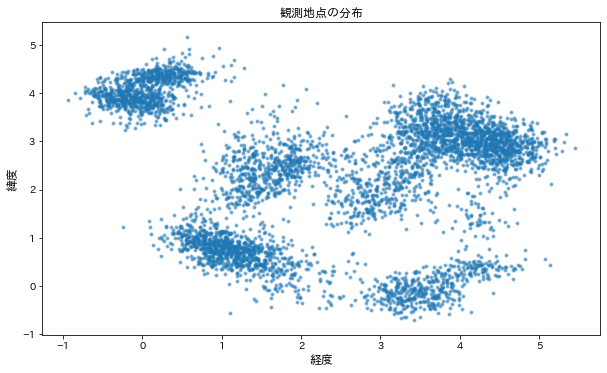

In [7]:
##観測地点間の距離分布を生成
#場所集合のトピックを生成
s = 30
prob = np.random.dirichlet(np.repeat(1.0, s), 1).reshape(-1)
point = np.dot(np.random.multinomial(1, prob, N), np.arange(s))
n = np.array([np.sum(point==j) for j in range(s)])

#観測地点の経緯度を生成
longitude = np.array([0, 5]); latitude = np.array([0, 5])
geo_spot0 = np.zeros((N, 2))
for j in range(s):
    index = np.array(np.where(point==j)[0], dtype="int")
    mu = np.append(np.random.uniform(longitude[0], longitude[1]), np.random.uniform(latitude[0], latitude[1]))
    Cov = np.diag(np.random.uniform(0.01, 0.15, 2))
    cor = np.random.uniform(-0.6, 0.6, 1) * np.prod(np.sqrt(np.diag(Cov)))
    Cov[0, 1] = cor; Cov[1, 0] = cor
    geo_spot0[index, ] = np.random.multivariate_normal(mu, Cov, n[j])
    
geo_spot = np.min(geo_spot0) + geo_spot0

#経緯度を可視化
fig = plt.figure(figsize=(10.0, 5.75))
plt.scatter(geo_spot[:, 0], geo_spot[:, 1], alpha=0.5, linewidths="2", s=4)
plt.title("観測地点の分布")
plt.xlabel("経度", fontsize=12.0)
plt.ylabel("緯度", fontsize=12.0)

Text(0, 0.5, 'ユークリッド距離')

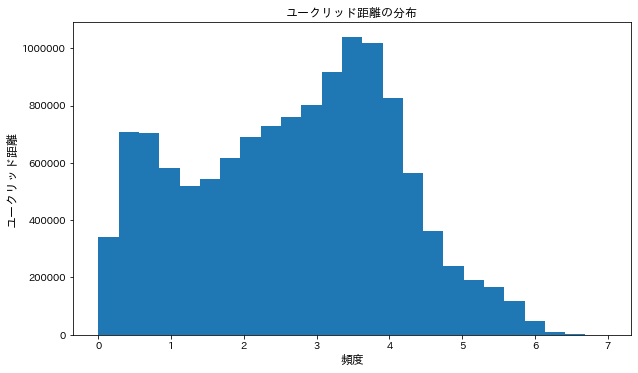

In [8]:
#場所間のユークリッド距離を定義
d = np.zeros((N, N), dtype="float32")
for i in range(N):
    d[i, ] = np.sqrt(np.sum(np.power(geo_spot[np.repeat(i, N), ] - geo_spot, 2), axis=1))

#分布を可視化
fig = plt.figure(figsize=(10.0, 5.75))
plt.hist(d[np.triu(d, k=1)!=0.0], bins=25)
plt.title("ユークリッド距離の分布")
plt.xlabel("頻度", fontsize=12.0)
plt.ylabel("ユークリッド距離", fontsize=12.0)

In [32]:
####応答変数を生成####
rp = 0
while True:
    rp = rp + 1
    print(rp)

    ##パラメータの生成
    #分散共分散行列を生成
    phi = np.array([1.5])
    tau = np.array([0.2])
    Sigma = np.array([1.5])
    theta = np.array([phi, tau, Sigma]).reshape(-1)
    Cov = tau*I + Sigma*np.exp(-phi * d)
    phit = phi.copy(); taut = tau.copy(); Sigmat = Sigma.copy()
    thetat = theta.copy(); Covt = Cov.copy()

    #回帰ベクトルを生成
    beta1 = np.array([10.0])
    beta2 = np.random.normal(0, 0.75, k-1)
    beta = np.append(beta1, beta2)
    betat = beta.copy()

    #応答変数を生成
    mu = np.dot(x, beta)
    y = mu + np.random.multivariate_normal(np.repeat(0.0, N), Cov, 1).reshape(-1)

    #break条件
    if np.min(y) > 0.0:
        break

1


Text(0.5, 0, '頻度')

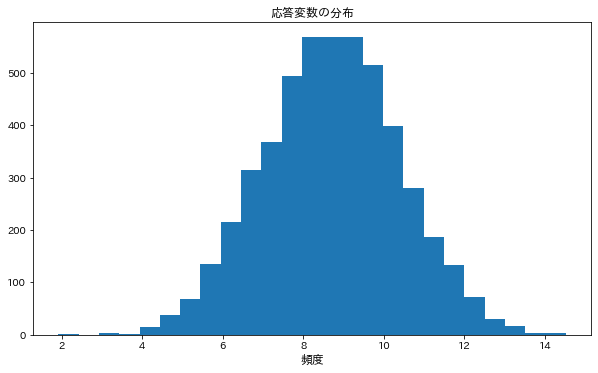

In [35]:
#応答変数を可視化
fig = plt.figure(figsize=(10.0, 5.75))
plt.hist(y, bins=25)
plt.title("応答変数の分布")
plt.xlabel("頻度", fontsize=12.0)

In [ ]:
####最尤法でパラメータを推定####
##Spatial Linear Regression modelを推定するための関数
#対数尤度の和を計算する関数

